In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
import scipy.interpolate as sci
import skfmm
from scipy.special import erf

Ra = 1e12
Pr = 1
nu = np.sqrt(Pr/Ra)
Lx = 2
Nr = 2048
Nphi = 2*Nr
nx = Nr*2

# optimal mask parameters (smoothness), given fluid viscosity ν and damping rate γ
ν = nu # viscosity [L**2/T]
γ = 100 # damping rate [1/T]
ϵ = (ν/γ)**(1/2) # damping length scale ϵ = (ν/γ)**(1/2), 
optimal_delta = 3.11346786*ϵ # erf mask smoothness
grid_delta = Lx/nx
δ = np.max((10*optimal_delta, grid_delta*2))
print(optimal_delta, grid_delta, δ)
print(10*optimal_delta, grid_delta*2, δ)

0.000311346786 0.00048828125 0.00311346786
0.00311346786 0.0009765625 0.00311346786


In [13]:
# image file from:
# https://commons.wikimedia.org/wiki/File:Yin%26Yang_trasparent.png
# license: public domain
im0 = image.imread('moose_1920px.jpg')
#fuss with pixels so full moose fits.
pad = 90
im = np.ones((im0.shape[0] + 2*pad, im0.shape[1] + 2*pad, 3))*255
im[pad:-pad, pad:-pad,:] = im0
im = im[pad:, pad:, :]

In [14]:
def mask(x): return 0.5*(1-erf(np.pi**(1/2)*x))

In [15]:
cell = np.asarray(im)[:,:,2]
cell = 1-(cell-np.min(cell))/(np.max(cell)-np.min(cell)) - .5 # boundary at cell == 0
# the signed distance function
distance = skfmm.distance(cell, dx = Lx/cell.shape[0])

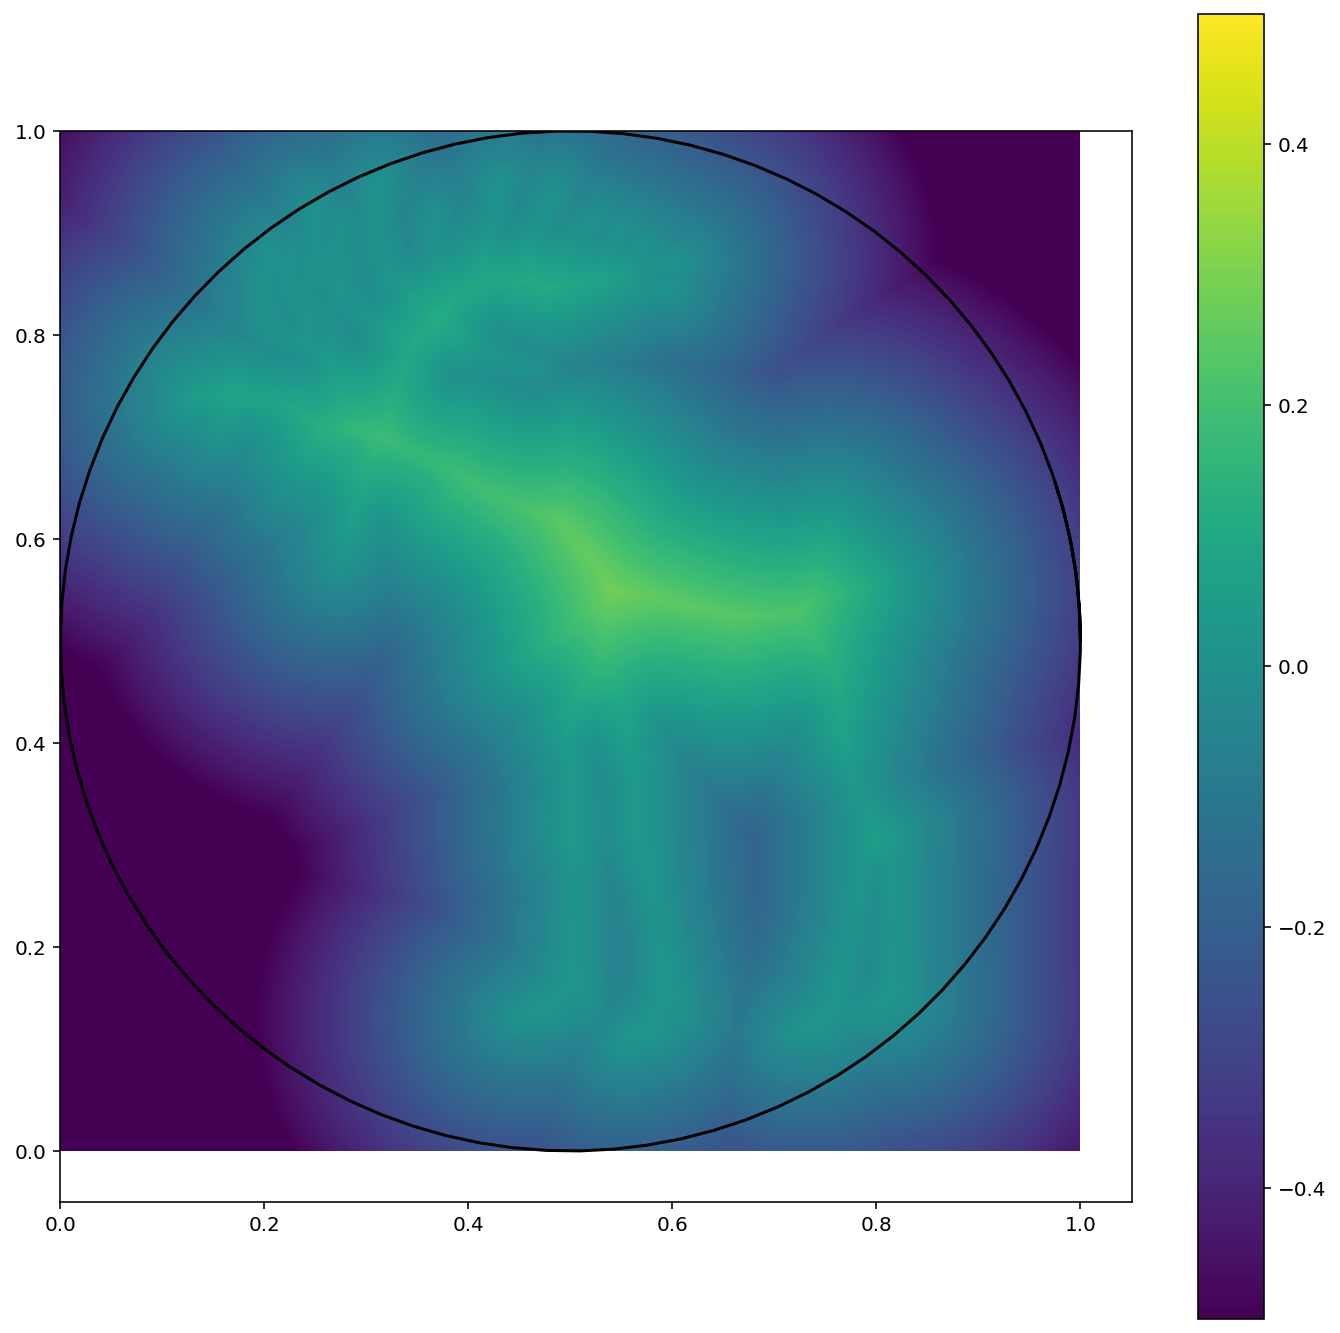

In [16]:
theta = np.linspace(0, 2.1*np.pi, 100)
x_circ = 0.5+0.5*np.cos(theta)
y_circ = 0.5+0.5*np.sin(theta)

y = 1-np.arange(cell.shape[0])/cell.shape[0]
x = np.arange(cell.shape[1])/cell.shape[1]

fig, ax = plt.subplots(figsize=[12,12])
mesh = ax.pcolormesh(x, y, distance, shading='auto', vmin=-0.5, vmax=0.5)
ax.set_aspect(1)
plt.colorbar(mesh)
plt.plot(x_circ, y_circ, c='k')

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gn/T/ipykernel_83028/2924596112.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax.pcolormesh(x, y, mask(distance/δ),cmap='Greys')


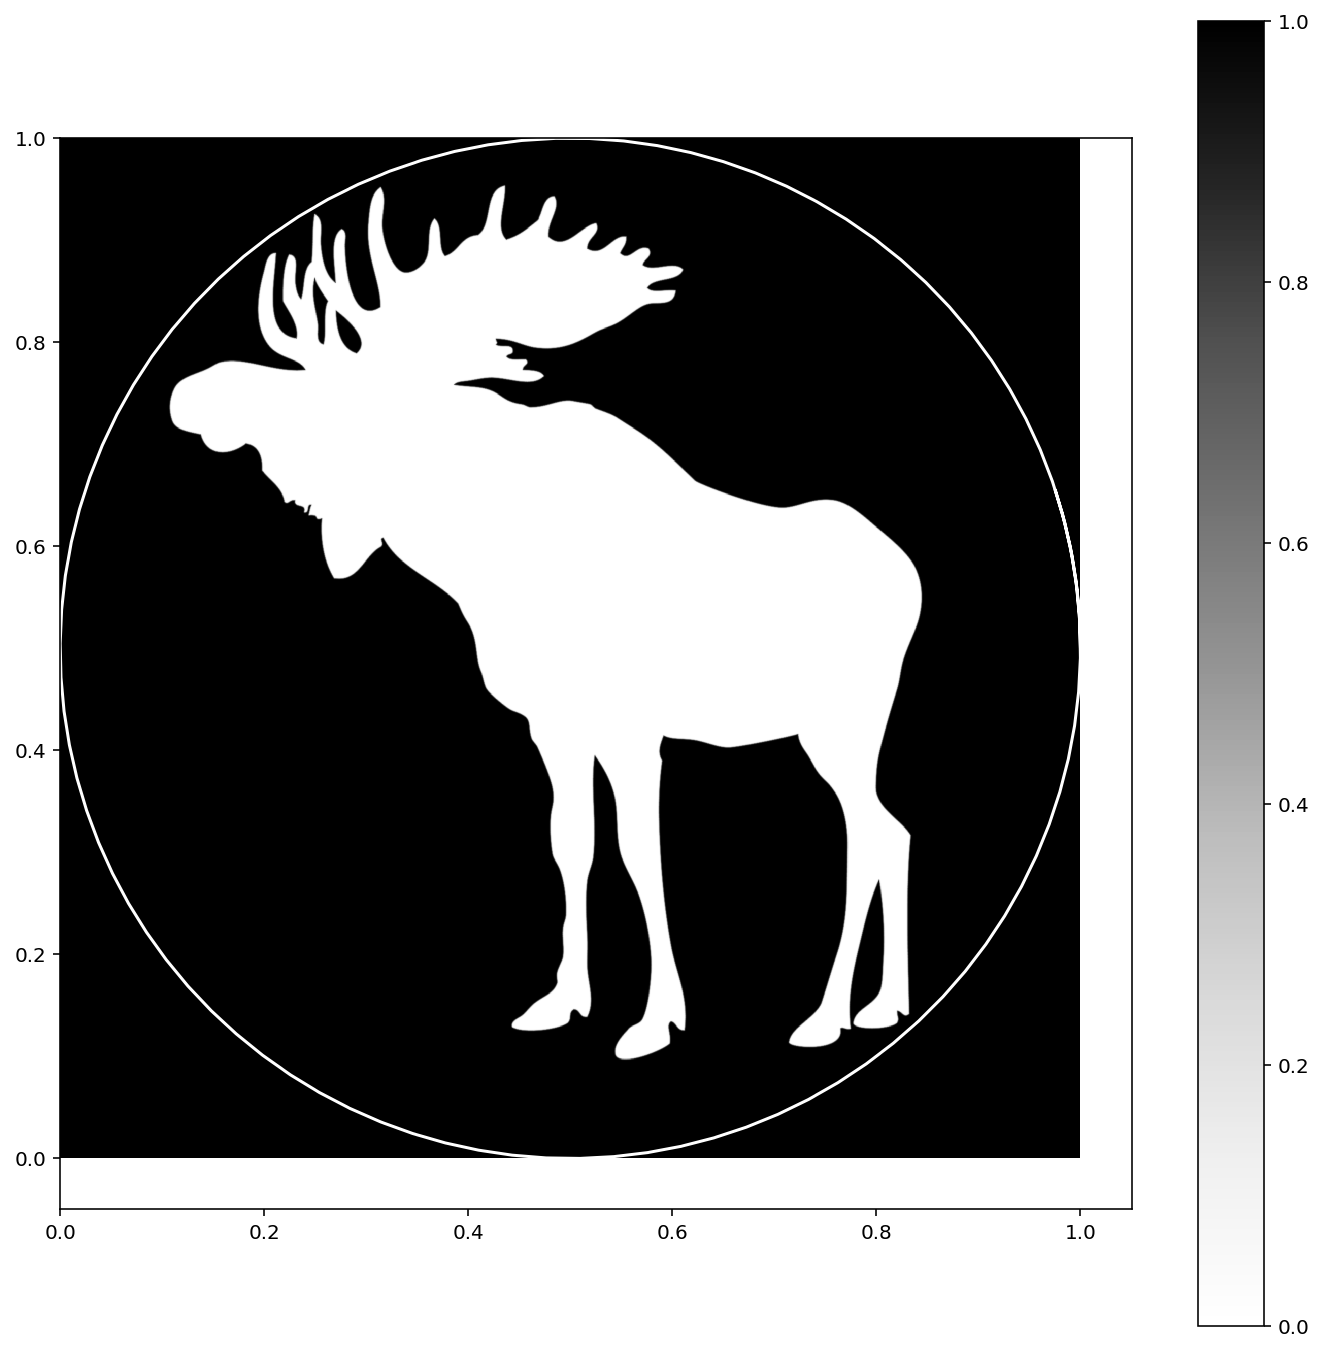

In [17]:
# plot of optimal mask
# see https://www.sciencedirect.com/science/article/pii/S0021999120308172?via%3Dihub
fig, ax = plt.subplots(figsize=[12,12])
plot = ax.pcolormesh(x, y, mask(distance/δ),cmap='Greys')
ax.set(aspect=1)
plt.colorbar(plot,ax=ax)
plt.plot(x_circ, y_circ, c='white')

In [18]:
import dedalus.public as d3

dtype = np.float64
dealias = 3/2

interp_smooth = sci.interp2d(x,y,mask(distance/δ))
#interp_smooth = sci.RegularGridInterpolator((x,1-y),mask(distance/δ), bounds_error=False, fill_value=1)

coords = d3.PolarCoordinates('phi', 'r')
dist = d3.Distributor(coords, dtype=dtype)
basis = d3.DiskBasis(coords, shape=(Nphi, Nr), radius=1, dealias=dealias, dtype=dtype, azimuth_library='matrix')


phi, r = basis.local_grids((dealias, dealias))
rr, pp = np.meshgrid(r, phi)
mask_grid = np.zeros_like(rr) #grid-locking a dealiased field is a huge memory hangup for some reason.

In [ ]:
for i in range(phi.shape[0]):
    for j in range(r.shape[1]):
        
        xl = (r[0,j]*(np.cos(phi[i,0])) + 1)/2
        yl = (r[0,j]*(np.sin(phi[i,0])) + 1)/2
        mask_grid[i,j] = interp_smooth(xl, yl)

In [ ]:
fig = plt.figure(figsize=[9,9])
ax = fig.add_subplot(1,1,1, polar=True)
ax.pcolormesh(pp, rr, mask_grid, shading='auto')

In [ ]:
import h5py
with h5py.File('./moosinesq_Ra{:.1e}_{}x{}_de{:.1f}_gamma{}.h5'.format(Ra, Nr,Nphi,dealias, γ), 'w') as f:
    print('./moosinesq_Ra{:.1e}_{}x{}_de{:.1f}_gamma{}.h5'.format(Ra, Nr,Nphi,dealias, γ))
    f['mask'] = mask_grid
    f['r'] = r
    f['phi'] = phi